In [14]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

In [14]:
!tar -xf inno_stats.tar.gz -C ./data

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [22]:
data_path = Path('./data/').resolve()
!ls {data_path}

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/data': No such file or directory


In [5]:
bad_ids = pd.read_csv('bad_ids.csv')

In [6]:
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


In [7]:
bad_ids_set = set(bad_ids['id_card'])

In [8]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [10]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [9]:
df_filtered = g_9[~g_9['id_card'].isin(bad_ids_set)]

In [10]:
df_filtered.count

<bound method DataFrame.count of                          date    id_doc  id_order  ...     sum  is_green  id_group
0         2020-09-01 17:01:25   1283228       0.0  ...  108.00         0     10004
1         2020-09-01 17:35:36   8873113       0.0  ...  108.00         0     10004
2         2020-09-01 19:19:21  12712899       0.0  ...  107.95         0     10004
3         2020-09-01 21:53:34  21535283       0.0  ...  108.00         0     10004
4         2020-09-01 18:42:31    642341       0.0  ...   88.00         0     10091
...                       ...       ...       ...  ...     ...       ...       ...
42100853  2020-09-30 11:26:28   4850561       0.0  ...  130.00         0     10099
42100854  2020-09-30 08:12:39  10015419       0.0  ...  120.00         0     10008
42100855  2020-09-30 09:54:24  22816791       0.0  ...   73.00         0     10254
42100856  2020-09-30 12:00:04   1648929       0.0  ...   78.00         0     10099
42100857  2020-09-30 09:37:16  22302533       0.0  ...

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

In [11]:
discount_products = df_filtered[df_filtered['is_green'] == 1]
discount_len = len(discount_products)
discount_len

2611563

In [12]:
discount = discount_products.groupby(by=['id_doc']).sum()['sum']
discount_mean = discount.mean()
discount_mean

190.68263650300798

In [13]:
without_discount = df_filtered[df_filtered['is_green'] == 0].sample(n=discount_len).groupby(by=['id_doc']).sum()['sum']
without_discount_mean = without_discount.mean()
without_discount_mean

156.27564660933706

In [16]:
ttest_ind(discount, without_discount)

Ttest_indResult(statistic=163.5735639028474, pvalue=0.0)

We have calculated the mean sum of check with discount products - *192.05* and non discount - *159.71*. The first mean is greater than second one that is why the assumption is proven.

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [17]:
df_filtered.index = pd.to_datetime(df_filtered['date'], format='%Y-%m-%d %H:%M:%S')
df_filtered.tail()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
date,,,,,,,,,,
2020-09-30 11:26:28,2020-09-30 11:26:28,4850561,0.0,1739990,25292,17528,1.0,130.0,0,10099
2020-09-30 08:12:39,2020-09-30 08:12:39,10015419,0.0,1761351,30740,19188,2.0,120.0,0,10008
2020-09-30 09:54:24,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.0,0,10254
2020-09-30 12:00:04,2020-09-30 12:00:04,1648929,0.0,484390,34835,15916,1.0,78.0,0,10099
2020-09-30 09:37:16,2020-09-30 09:37:16,22302533,0.0,557627,34835,15916,1.0,78.0,0,10099


In [18]:
buyings_amount = df_filtered.groupby(by=[df_filtered.index.day])['id_doc'].count()
buyings_amount

date
1     1269893
2     1285415
3     1287425
4     1270192
5     1053459
6     1158077
7     1371646
8     1227093
9     1336351
10    1305395
11    1284777
12    1087414
13    1168560
14    1370166
15    1316259
16    1326892
17    1181904
18    1429865
19    1168649
20    1206583
21    1370546
22    1352159
23    1343573
24    1336031
25    1364338
26    1130494
27    1220942
28    1415253
29    1411357
30    1415295
Name: id_doc, dtype: int64

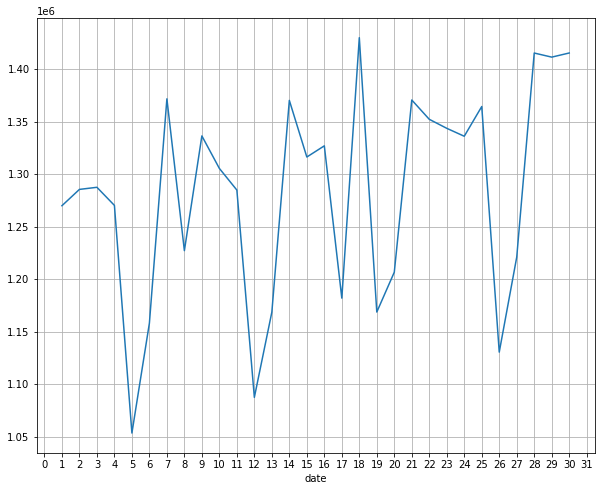

In [19]:
plt.figure(figsize=(10,8))
plt.locator_params(axis="x", nbins=50)
buyings_amount.plot()
plt.grid()

As we can see in the plot, the amount of buyings has local minima at 5th and 20th days, and huge growth after that. Assuming that these are wage taking days, the statement is proven. 

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

#### Frequent Buyers

In [20]:
frequent_buyers = df_filtered.groupby(by=['id_doc']).first()
frequent_buyers['id_card'].value_counts()[:50]

620767     161
1523082    119
943480     109
1567258    104
1808366    103
1144271    103
1284105    102
297039     101
1789392     98
904949      98
1472222     91
926464      89
439307      86
789143      78
919837      78
74300       77
1108476     76
1334945     76
1229061     76
974512      76
748538      75
1095114     75
1572245     74
563042      74
1161780     73
1609030     73
365710      72
516949      72
1817230     71
1107018     71
869122      71
1249323     71
204545      70
490358      70
1335412     69
1818799     69
842795      69
971273      69
1745221     68
562286      68
487974      68
759554      68
661917      68
675545      68
1572850     67
1507020     67
1326765     67
1785077     67
1226636     67
1393925     67
Name: id_card, dtype: int64

#### Orders amount

In [21]:
grouped_by_id = df_filtered.groupby(by=['id_card'])
orders_per_user = grouped_by_id.agg({"id_doc": "nunique"})
orders_per_user.head()
grouped_by_num_of_orders = orders_per_user.groupby(by=['id_doc'])
grouped_by_num_of_orders.groups

{1: [1, 2, 7, 9, 13, 18, 29, 40, 44, 58, 60, 62, 76, 85, 86, 87, 101, 114, 116, 124, 153, 182, 186, 190, 196, 205, 217, 223, 225, 229, 244, 254, 263, 274, 276, 278, 279, 308, 311, 313, 316, 323, 332, 337, 371, 372, 373, 380, 383, 385, 386, 387, 389, 397, 401, 402, 411, 415, 416, 417, 418, 426, 431, 433, 437, 443, 445, 446, 448, 453, 454, 458, 460, 461, 470, 475, 476, 478, 490, 493, 503, 504, 507, 514, 530, 534, 543, 555, 557, 561, 562, 564, 579, 598, 607, 608, 609, 610, 613, 614, ...], 2: [8, 21, 24, 33, 89, 111, 132, 148, 164, 206, 250, 260, 269, 270, 289, 291, 318, 348, 425, 427, 436, 440, 442, 450, 456, 466, 467, 486, 513, 518, 523, 546, 559, 563, 577, 581, 582, 584, 592, 595, 601, 625, 638, 643, 647, 654, 716, 719, 737, 742, 748, 754, 764, 789, 790, 802, 809, 821, 822, 853, 854, 867, 885, 889, 900, 901, 903, 908, 938, 942, 952, 963, 965, 968, 970, 975, 978, 995, 1003, 1016, 1028, 1029, 1045, 1048, 1052, 1065, 1066, 1075, 1101, 1107, 1115, 1125, 1135, 1156, 1157, 1182, 1207, 1211, 1

#### Usual cart

In [22]:
num_of_cusomers_per_group = df_filtered.groupby(by=['id_group'])['id_card'].unique().apply(len)
df_filtered.groupby(by=['id_group'])['id_card'].unique()

id_group
-9999     [1672691, 82434, 954793, 1572538, 1408606, 683...
 10004    [1538855, 267307, 610220, 441497, 389692, 3110...
 10005    [31109, 511852, 1254751, 563773, 736602, 16969...
 10008    [1360897, 954793, 1841743, 626319, 389640, 924...
 10012    [1572538, 297933, 149795, 469039, 1318057, 172...
                                ...                        
 10481    [178771, 245508, 518187, 73808, 175105, 161914...
 10499    [552726, 1220525, 294237, 303445, 742939, 2720...
 10503    [766318, 609754, 1822326, 1448679, 106364, 149...
 10506    [128411, 28540, 232592, 1306012, 499888, 17956...
 52194    [686029, 125830, 227162, 890413, 334262, 81074...
Name: id_card, Length: 164, dtype: object